In [362]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [363]:
datafile = "C:/Users/user1/Downloads/matala2_cosmetics_2019-Nov (1)/matala2_cosmetics_2019-Nov.csv"

In [364]:
df = pd.read_csv(datafile)

In [365]:
# q1

In [353]:
df['event_time'] = pd.to_datetime(df['event_time'])
df = df.sort_values(['user_session', 'event_time'])
df['duration_to_next_event'] = (df.groupby('user_session')['event_time'].diff(-1) * -1).dt.seconds
df.loc[df.groupby('user_session')['event_time'].idxmax(), 'duration_to_next_event'] = 0
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,duration_to_next_event,funnel_number,index_in_funnel
8,2019-11-01 00:01:23+00:00,view,5837825,1933472286753424063,NaN,NaN,3.49,514649199,037e2ba9-1446-49c6-9723-dcfa7f9da3b8,5.0,1,2
9,2019-11-01 00:01:28+00:00,cart,5837825,1933472286753424063,NaN,NaN,3.49,514649199,037e2ba9-1446-49c6-9723-dcfa7f9da3b8,0.0,1,3
17,2019-11-01 00:00:02+00:00,view,5802432,1487580009286598681,NaN,NaN,0.32,562076640,09fafd6c-6c99-46b1-834f-33527f4de241,23.0,1,1
18,2019-11-01 00:00:25+00:00,view,5856189,1487580009026551821,NaN,runail,15.71,562076640,09fafd6c-6c99-46b1-834f-33527f4de241,25.0,1,2
19,2019-11-01 00:00:50+00:00,view,5856190,1487580009026551821,NaN,runail,15.71,562076640,09fafd6c-6c99-46b1-834f-33527f4de241,7.0,1,3


In [354]:
df = df.sort_values(by=['user_id', 'event_time'])
df['time_diff'] = df.groupby('user_id')['event_time'].diff().dt.days.apply(lambda x: 1 if x > 5 else 0)
df['funnel_number'] = df.groupby('user_id')['time_diff'].cumsum()
df['funnel_number'] = df['funnel_number'] +1
df.drop('time_diff', axis = 1, inplace = True)
df

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,duration_to_next_event,funnel_number,index_in_funnel
0,2019-11-01 00:01:11+00:00,view,5759991,1487580013212467384,NaN,NaN,15.08,391027139,8b820c4f-4cee-4407-9f6a-dc0f926959bb,0.0,1,1
1,2019-11-01 00:00:34+00:00,remove_from_cart,5870838,1487580007675986893,NaN,milv,0.79,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a,3.0,1,1
2,2019-11-01 00:00:37+00:00,view,5870803,1487580007675986893,NaN,milv,0.79,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a,5.0,1,2
3,2019-11-01 00:00:42+00:00,remove_from_cart,5870803,1487580007675986893,NaN,milv,0.79,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a,4.0,1,3
4,2019-11-01 00:00:46+00:00,view,5841721,1487580008187692007,NaN,NaN,1.37,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a,21.0,1,4
5,2019-11-01 00:01:07+00:00,view,5780830,1487580005092295511,NaN,rosi,7.14,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a,0.0,1,5
6,2019-11-01 00:01:23+00:00,view,5745720,1487580006317032337,NaN,irisk,8.57,485066868,9eeee910-722d-495e-8335-c1e3efb00089,0.0,1,1
7,2019-11-01 00:00:32+00:00,view,5837835,1933472286753424063,NaN,NaN,3.49,514649199,432a4e95-375c-4b40-bd36-0fc039e77580,0.0,1,1
8,2019-11-01 00:01:23+00:00,view,5837825,1933472286753424063,NaN,NaN,3.49,514649199,037e2ba9-1446-49c6-9723-dcfa7f9da3b8,5.0,1,2
9,2019-11-01 00:01:28+00:00,cart,5837825,1933472286753424063,NaN,NaN,3.49,514649199,037e2ba9-1446-49c6-9723-dcfa7f9da3b8,0.0,1,3


# q3

In [355]:
df = df.sort_values(['funnel_number', 'user_id'])
df['index_in_funnel'] = 1
df['index_in_funnel'] = df.groupby(['user_id','funnel_number'] )['index_in_funnel'].cumsum()
df['funnel_number'].value_counts()

1    25
Name: funnel_number, dtype: int64

In [356]:
pattern = r'(\d+\.\d+)'
df['price'] = df['price'].astype(str).apply(lambda x: float(re.search(pattern, x).group(1)))
#df.to_csv(datafile, index=False)
print(df['price'].dtype)

float64


# q4

In [357]:
price_pattern = re.compile(r'\d+\.\d+')
df['price'] = df['price'].astype(str).apply(lambda x: float(price_pattern.findall(x)[0]) if price_pattern.findall(x) else None)
#df
print(df['price'].dtype)

float64


# q5

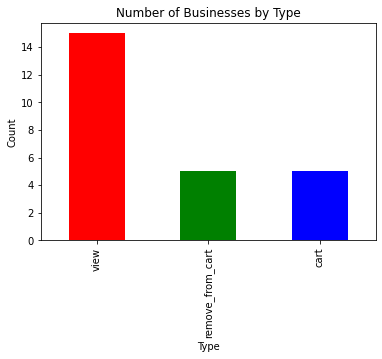

In [358]:
type_counts = df['event_type'].value_counts()
plt.title('Number of Businesses by Type')
plt.xlabel('Type')
plt.ylabel('Count')
colors = ['red', 'green', 'blue', 'orange']
type_counts.plot.bar(color=colors)
plt.show()

# q6

In [359]:
session_data = df[['user_id', 'user_session', 'funnel_number', 'index_in_funnel' ]]#.groupby('user_session')
session_data

,user_id,user_session,funnel_number,index_in_funnel
0,391027139,8b820c4f-4cee-4407-9f6a-dc0f926959bb,1,1
1,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a,1,1
2,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a,1,2
3,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a,1,3
4,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a,1,4
5,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a,1,5
6,485066868,9eeee910-722d-495e-8335-c1e3efb00089,1,1
7,514649199,432a4e95-375c-4b40-bd36-0fc039e77580,1,1
8,514649199,037e2ba9-1446-49c6-9723-dcfa7f9da3b8,1,2
9,514649199,037e2ba9-1446-49c6-9723-dcfa7f9da3b8,1,3


In [361]:
#df['event_type'] = df[df['event_type'].isin(['view', 'cart', 'purchase'])]
data = df.groupby(['user_session', 'event_type']).agg(
{
    'index_in_funnel' : "last",
    'product_id': lambda x: list(x),
    
}).reset_index()


pivot = data.pivot_table(index='user_session', columns= 'event_type', values='product_id',aggfunc='first')
session_data = pd.merge(session_data, pivot, on='user_session')
session_data.rename(columns={'view': 'list_of_viewed', 'cart': 'list_of_added_to_cart ', 'remove_from_cart': 'remove_from_cart'}, inplace=True)
session_data['visit_duration'] = df.groupby(['funnel_number', 'user_session'])[["duration_to_next_event"]].transform('sum')
session_data['total_event'] = df.groupby('user_session')[['event_type']].transform('count')
session_data

,user_id,user_session,funnel_number,index_in_funnel,list_of_added_to_cart,remove_from_cart_x,list_of_viewed,visit_duration,list_of_added_to_cart,remove_from_cart_y,list_of_viewed,total_event
0,391027139,8b820c4f-4cee-4407-9f6a-dc0f926959bb,1,1,NaN,NaN,[5759991],0.0,NaN,NaN,[5759991],1
1,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a,1,1,NaN,"[5870838, 5870803]","[5870803, 5841721, 5780830]",33.0,NaN,"[5870838, 5870803]","[5870803, 5841721, 5780830]",5
2,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a,1,2,NaN,"[5870838, 5870803]","[5870803, 5841721, 5780830]",33.0,NaN,"[5870838, 5870803]","[5870803, 5841721, 5780830]",5
3,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a,1,3,NaN,"[5870838, 5870803]","[5870803, 5841721, 5780830]",33.0,NaN,"[5870838, 5870803]","[5870803, 5841721, 5780830]",5
4,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a,1,4,NaN,"[5870838, 5870803]","[5870803, 5841721, 5780830]",33.0,NaN,"[5870838, 5870803]","[5870803, 5841721, 5780830]",5
5,429913900,2f0bff3c-252f-4fe6-afcd-5d8a6a92839a,1,5,NaN,"[5870838, 5870803]","[5870803, 5841721, 5780830]",33.0,NaN,"[5870838, 5870803]","[5870803, 5841721, 5780830]",5
6,485066868,9eeee910-722d-495e-8335-c1e3efb00089,1,1,NaN,NaN,[5745720],0.0,NaN,NaN,[5745720],1
7,514649199,432a4e95-375c-4b40-bd36-0fc039e77580,1,1,NaN,NaN,[5837835],0.0,NaN,NaN,[5837835],1
8,514649199,037e2ba9-1446-49c6-9723-dcfa7f9da3b8,1,2,[5837825],NaN,[5837825],5.0,[5837825],NaN,[5837825],2
9,514649199,037e2ba9-1446-49c6-9723-dcfa7f9da3b8,1,3,[5837825],NaN,[5837825],5.0,[5837825],NaN,[5837825],2
